In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches

In [3]:
np.random.seed(101)

In [4]:
# Define parameters
N = 500
T = 300
M = 50000
dt = 0.01
t0 = 0

pi = np.pi

k = 1
a = 0.1
b = 0.26
c = -65
d = 0 #-1

A = 0.04
B = 5
C = 140

# v_reset = -100/A - B/(2*A)
# v_thresh = 100/A - B/(2*A) 

v_reset = -1000
v_thresh = 1000


Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

p_jump = 2.7185823035951033

# Heterogeneity parameters for the intrinsic current eta
Delta = 0.02     # half-width of Lorentzian for eta
etaBar = 0.8 # mean intrinsic current

J = stats.cauchy.rvs(loc=etaBar, scale=Delta, size=N)
I = 0

# All-to-all connected, can use single s and p as all neuron receive same input
g = 0.2


In [4]:
J.mean()

0.7607840759058888

In [5]:
# Network simulation functions
def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N]
    p = x[-1]
    
    dvdt = k * (A*v**2 + B*v + C - u + I) + J - (v - Esyn)*g*s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, [dsdt], [dpdt]])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

In [6]:
# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average firing rate 41.13


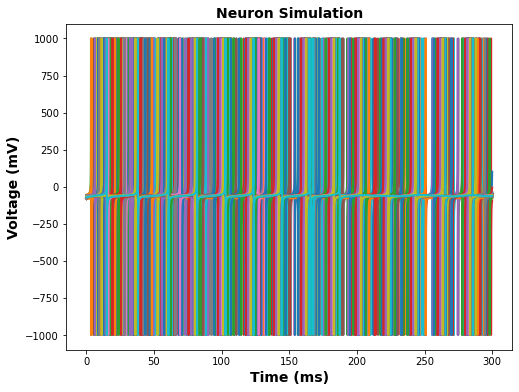

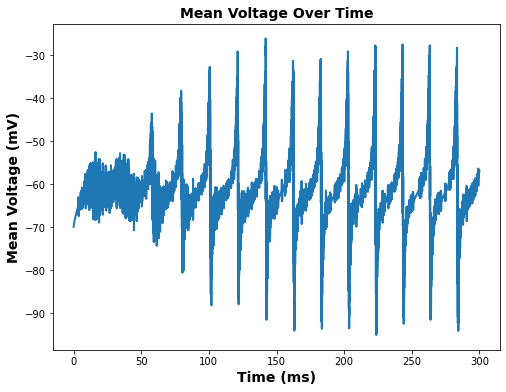

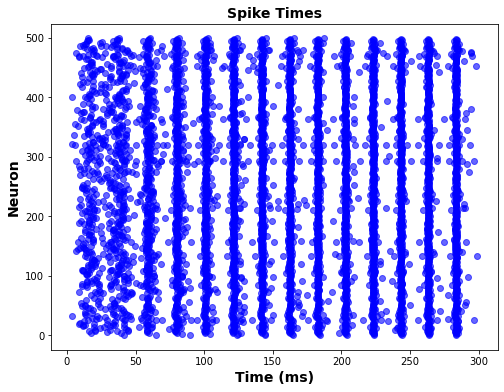

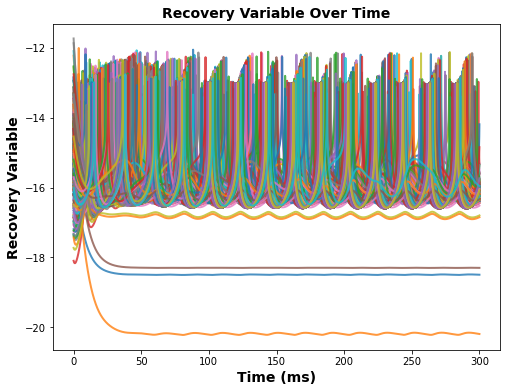

In [7]:
# etaBar = 1
# Initial conditions
v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 1, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = 0
p_init = 0

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, [s_init], [p_init]])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, [s_init], [p_init]])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t], axis=0)
    y_all = np.concatenate([y_all, y], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N, -1]
    p_init = y[-1, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += p_jump/N #x0 
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


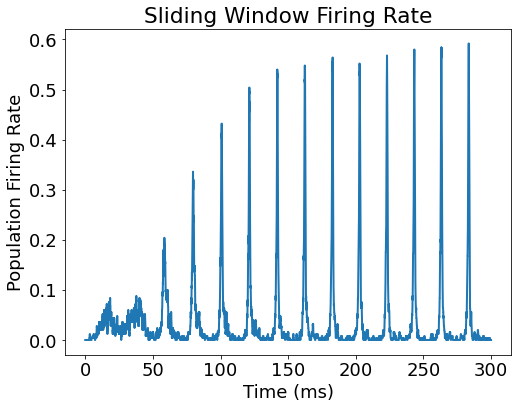

Mean Firing Rate: 37.720000000000006 Hz
Average firing rate in the first 100 ms: 0.03125000000000001 Hz


In [8]:
def compute_sliding_window_firing_rate(spike_times, N, T,
                                       window_size=10,  # ms
                                       step_size=0.05):  # ms
    
    # All spike times (in ms) in sorted order:
    spike_t = spike_times[:, 0]
    # Ensure sorted by time (if not already)
    spike_t_sorted = np.sort(spike_t)

    # We will collect time bins from 0 to T in increments of step_size
    time_bins = np.arange(0, T, step_size)
    fr_array = np.zeros_like(time_bins)

    # Convert ms to s for rates in Hz:
    ms_to_s = 1

    for i, t_start in enumerate(time_bins):
        t_end = t_start + window_size
        # Count how many spikes occurred in [t_start, t_end)
        # "spikes_in_win" is how many spike times fall in that interval
        mask = (spike_t_sorted >= t_start) & (spike_t_sorted < t_end)
        num_spikes_in_window = np.sum(mask)

        # Window duration in seconds
        w_sec = window_size * ms_to_s

        # Rate in spikes/(neuron·second) a.k.a. Hz:
        fr_array[i] = num_spikes_in_window / (N * w_sec)

    return time_bins, fr_array

valid_spikes = spike_times[:spikeCounter, :]  # shape (actual_spike_count, 2)

time_bins, fr_array = compute_sliding_window_firing_rate(valid_spikes, N, T,
                                                         window_size=0.5,
                                                         step_size=0.05)

plt.figure(figsize=(8,6))
plt.plot(time_bins, fr_array, lw=2)
plt.xlabel("Time (ms)")
plt.ylabel("Population Firing Rate")  # if used ms->s conversion
plt.title("Sliding Window Firing Rate")
plt.show()

mean_firing_rate = np.mean(fr_array)
print(f"Mean Firing Rate: {mean_firing_rate*1e3} Hz")
# After computing time_bins and fr_array as in your code:
time_bins, fr_array = compute_sliding_window_firing_rate(
    valid_spikes, N, T, window_size=0.5, step_size=0.05
)

# Create a boolean mask selecting only the indices corresponding to < 100 ms
mask_100ms = time_bins < 100  # first 100 ms

# Take the mean of fr_array over those indices
mean_fr_100ms = np.mean(fr_array[mask_100ms])

# If you want the value in Hz (spikes/s), multiply by 1e3
mean_fr_100ms_hz = mean_fr_100ms 

print(f"Average firing rate in the first 100 ms: {mean_fr_100ms_hz} Hz")


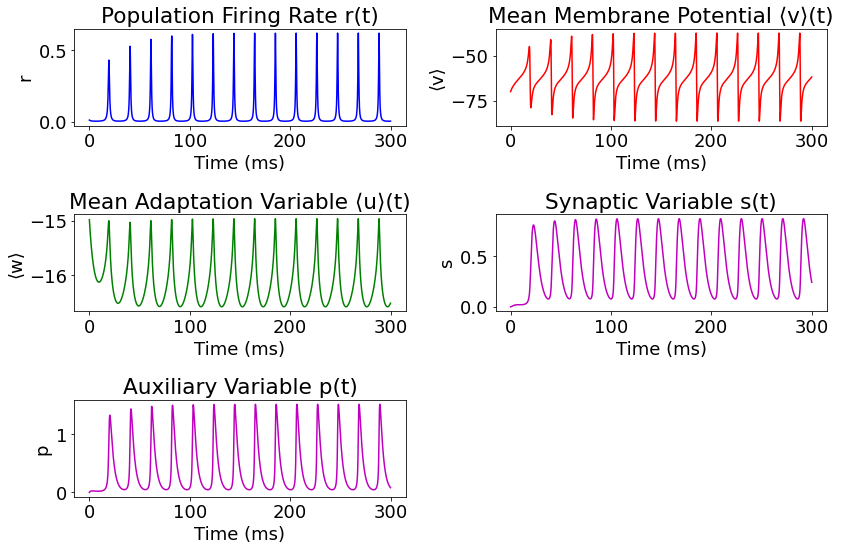

In [9]:
# etaBar=1
# Delta=0.1
T = 300
# Set simulation parameters
t_eval = np.linspace(0, T, 10000)

# Initial conditions for [r(0), ⟨v⟩(0), ⟨u⟩(0), s(0)]
y0 = [0.01, y_all[:N,0].mean(), y_all[N:2*N,0].mean(), 0, 0]

# Solve the ODE system
sol = solve_ivp(mean_field_odes, [0,T], y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(sol.t, sol.y[0], 'b')
plt.title('Population Firing Rate r(t)')
plt.xlabel('Time (ms)')
plt.ylabel('r')

plt.subplot(3, 2, 2)
plt.plot(sol.t, sol.y[1], 'r')
plt.title('Mean Membrane Potential ⟨v⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨v⟩')

plt.subplot(3, 2, 3)
plt.plot(sol.t, sol.y[2], 'g')
plt.title('Mean Adaptation Variable ⟨u⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨w⟩')

plt.subplot(3, 2, 4)
plt.plot(sol.t, sol.y[3], 'm')
plt.title('Synaptic Variable s(t)')
plt.xlabel('Time (ms)')
plt.ylabel('s')

plt.subplot(3, 2, 5)
plt.plot(sol.t, sol.y[4], 'm')
plt.title('Auxiliary Variable p(t)')
plt.xlabel('Time (ms)')
plt.ylabel('p')

plt.tight_layout()
plt.show()


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


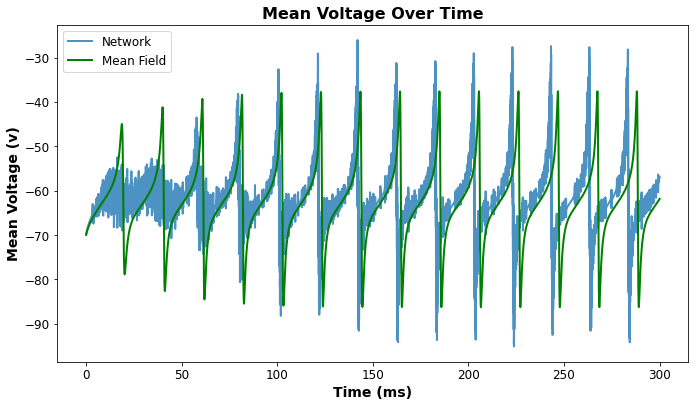

In [10]:
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2, alpha=0.8, label='Network')
plt.plot(sol.t, sol.y[1], 'g', linewidth=2, label='Mean Field')

# Add a bold title
plt.title("Mean Voltage Over Time", fontsize=16, fontweight='bold')

# Make axes labels larger and bold
plt.xlabel("Time (ms)", fontsize=14, fontweight='bold')
plt.ylabel("Mean Voltage (v)", fontsize=14, fontweight='bold')

# Control tick parameters for readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a legend with slightly larger font
plt.legend(fontsize=12)

# Make layout tight so labels are not cut off
plt.tight_layout()
plt.savefig('MeanVoltage_EtaBar_1.0.png')
# Show the plot
plt.show()


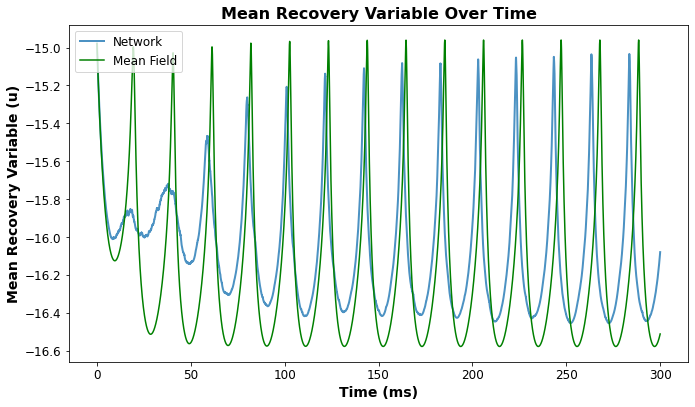

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(t_all, y_all[N:2*N, :].mean(axis=0), linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[2], 'g', label = 'Mean Field')
# Add a bold title
plt.title("Mean Recovery Variable Over Time", fontsize=16, fontweight='bold')

# Make axes labels larger and bold
plt.xlabel("Time (ms)", fontsize=14, fontweight='bold')
plt.ylabel("Mean Recovery Variable (u)", fontsize=14, fontweight='bold')

# Control tick parameters for readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a legend with slightly larger font
plt.legend(fontsize=12)

# Make layout tight so labels are not cut off
plt.tight_layout()
plt.savefig('MeanRecoveryVariable_EtaBar_1.0.png')
# Show the plot
plt.show()

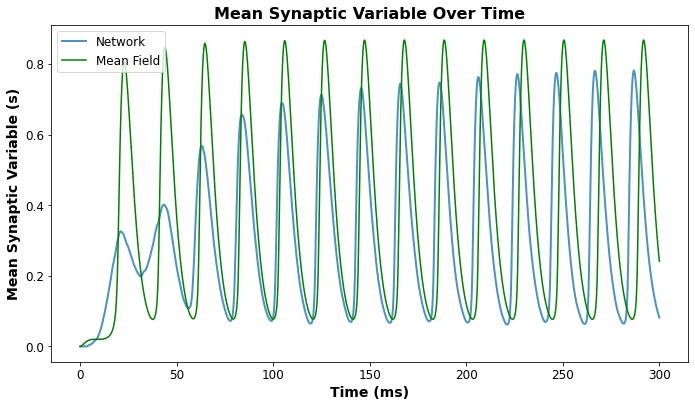

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(t_all, y_all[-2, :], linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[3], 'g', label = 'Mean Field')
# Add a bold title
plt.title("Mean Synaptic Variable Over Time", fontsize=16, fontweight='bold')

# Make axes labels larger and bold
plt.xlabel("Time (ms)", fontsize=14, fontweight='bold')
plt.ylabel("Mean Synaptic Variable (s)", fontsize=14, fontweight='bold')

# Control tick parameters for readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a legend with slightly larger font
plt.legend(fontsize=12)

# Make layout tight so labels are not cut off
plt.tight_layout()
plt.savefig('MeanSynapticVariable_EtaBar_1.0.png')
# Show the plot
plt.show()

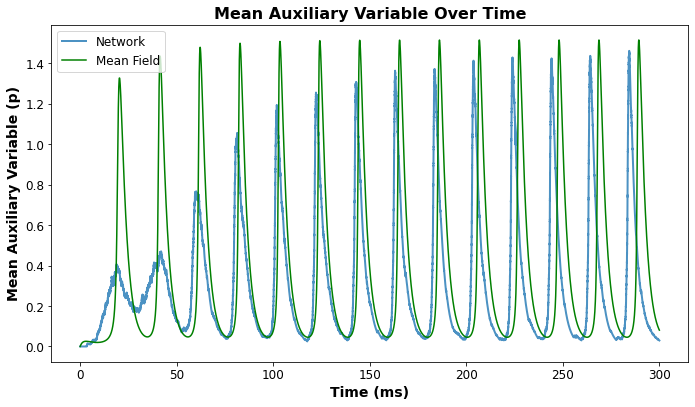

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(t_all, y_all[-1, :], linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[4], 'g', label = 'Mean Field')
# Add a bold title
plt.title("Mean Auxiliary Variable Over Time", fontsize=16, fontweight='bold')

# Make axes labels larger and bold
plt.xlabel("Time (ms)", fontsize=14, fontweight='bold')
plt.ylabel("Mean Auxiliary Variable (p)", fontsize=14, fontweight='bold')

# Control tick parameters for readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a legend with slightly larger font
plt.legend(fontsize=12)

# Make layout tight so labels are not cut off
plt.tight_layout()
plt.savefig('MeanAuxiliaryVariable_EtaBar_1.0.png')
# Show the plot
plt.show()

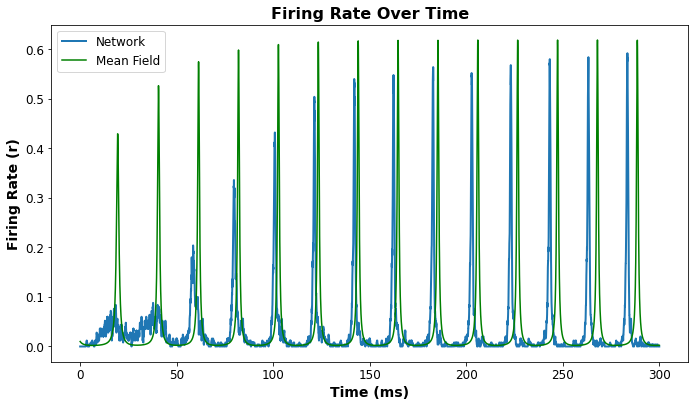

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(time_bins, fr_array, lw=2, label = 'Network')
plt.plot(sol.t, sol.y[0], 'g', label = 'Mean Field')
# Add a bold title
plt.title("Firing Rate Over Time", fontsize=16, fontweight='bold')

# Make axes labels larger and bold
plt.xlabel("Time (ms)", fontsize=14, fontweight='bold')
plt.ylabel("Firing Rate (r)", fontsize=14, fontweight='bold')

# Control tick parameters for readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a legend with slightly larger font
plt.legend(fontsize=12)

# Make layout tight so labels are not cut off
plt.tight_layout()
plt.savefig('FiringRate_EtaBar_1.0.png')
# Show the plot
plt.show()